# Titanic Analysis

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

From the problem statement, we have the following features:

| Variable |               Definition              |
|:--------:|:-------------------------------------:|
| survived |      Whether or not they survived     |
|  pclass  |              Ticket class             |
|    sex   |                  Sex                  |
|    age   |              Age in years             |
|   sibsp  | Number of siblings and spouses aboard |
|   parch  | Number of parents and children aboard |
|  ticket  |             Ticket number             |
|   fare   |             Passenger fare            |
|   cabin  |              Cabin number             |
| embarked |          Port of embarkation          |

## Getting to know the data

Let's get an idea of the data we're working with.

In [130]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
345,346,1,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.0000,F33,S
67,68,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,NaN,S
564,565,0,3,"Meanwell, Miss. (Marion Ogden)",female,NaN,0,0,SOTON/O.Q. 392087,8.0500,NaN,S
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S


The PassengerID and Ticket variables are just identifiers that have no impact on the survival probability. Therefore, they will be excluded from the analysis.

We will also replace male and female with 0 and 1, respectively.

In [131]:
test_ids = test_df["PassengerId"]

df.drop(["PassengerId", "Ticket", "Name"], axis=1, inplace=True)
test_df.drop(["PassengerId", "Ticket", "Name"], axis=1, inplace=True)

df["Sex"].replace(['male', 'female'], [0, 1], inplace=True)
test_df["Sex"].replace(['male', 'female'], [0, 1], inplace=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


Oh crap, looks like we have a lot of missing values. Let's see exactly how many.

In [132]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [133]:
test_df.isna().sum()

Pclass        0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

## Filling in missing values

Here we have 177 missing values in the `Age` column. For now I will just fill it in with the median age (which is 28). We also only have two missing values in the `Embarked` column so we fill them with the most common embarkation point (which is S).

I don't think there's much we can do about the `Cabin` values. We will probably remove this column entirely because of too many missing values.

In [134]:
df.Age.fillna(df.Age.median(), inplace=True)
test_df.Age.fillna(test_df.Age.median(), inplace=True)

df.Embarked.fillna(df.Embarked.mode()[0], inplace=True)

test_df.Fare.fillna(test_df.Fare.median(), inplace=True)

df.drop("Cabin", axis=1, inplace=True)
test_df.drop("Cabin", axis=1, inplace=True)

### Check

In [135]:
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [136]:
test_df.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [137]:
df.sample(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
336,0,1,0,29.0,1,0,66.6000,S
316,1,2,1,24.0,1,0,26.0000,S
495,0,3,0,28.0,0,0,14.4583,C


## Adding more features

We add the feature FamilySize, which is equal to sibsp + parch + 1.

In [138]:
df["FamilySize"] = df.SibSp + df.Parch + 1
test_df["FamilySize"] = test_df.SibSp + test_df.Parch + 1
df.sample(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
760,0,3,0,28.0,0,0,14.5000,S,1
665,0,2,0,32.0,2,0,73.5000,S,3
601,0,3,0,28.0,0,0,7.8958,S,1


We add the feature Alone, which tells us if the passenger is alone or not.

In [139]:
df["Alone"] = [int(x) for x in df.FamilySize == 1]
test_df["Alone"] = [int(x) for x in test_df.FamilySize == 1]

In [140]:
df.sample(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Alone
849,1,1,1,28.0,1,0,89.1042,C,2,0
767,0,3,1,30.5,0,0,7.7500,Q,1,1
156,1,3,1,16.0,0,0,7.7333,Q,1,1


We add the feature Child, which tells us if the passenger is under 6 years old.

In [141]:
df["Child"] = [int(x) for x in df.Age <= 6]
test_df["Child"] = [int(x) for x in test_df.Age <= 6]
df.sample(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Alone,Child
373,0,1,0,22.0,0,0,135.6333,C,1,1,0
783,0,3,0,28.0,1,2,23.4500,S,4,0,0
599,1,1,0,49.0,1,0,56.9292,C,2,0,0


## Scale Variables

In [142]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#We need to reshape our data since the Scaler takes in arrays
ages_train = np.array(df["Age"]).reshape(-1, 1)
fares_train = np.array(df["Fare"]).reshape(-1, 1)

df["Age"] = scaler.fit_transform(ages_train)
df["Fare"] = scaler.fit_transform(fares_train)

df.sample(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Alone,Child
680,0,3,1,-0.104637,0,0,-0.484576,Q,1,1,0
827,1,2,0,-2.179583,0,2,0.096646,C,3,0,1
684,0,2,0,2.354558,1,1,0.136831,S,3,0,0


## Exploratory Data Analysis

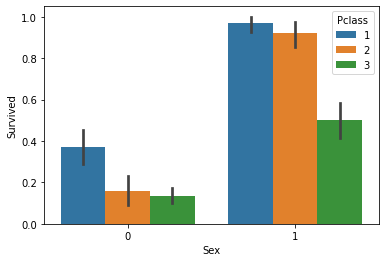

In [143]:
sns.barplot(x='Sex', y='Survived', hue="Pclass", data=df);

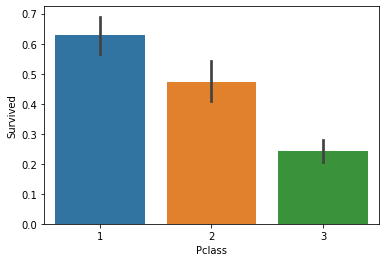

In [144]:
sns.barplot(x='Pclass', y='Survived', data=df);

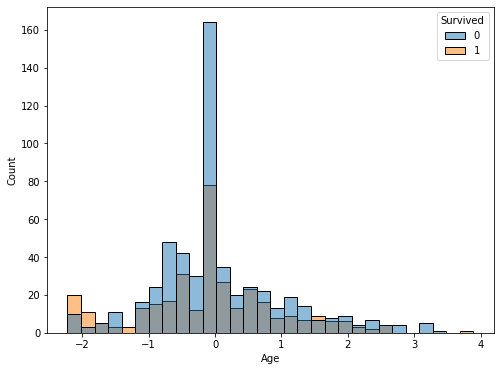

In [145]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Age", hue="Survived");

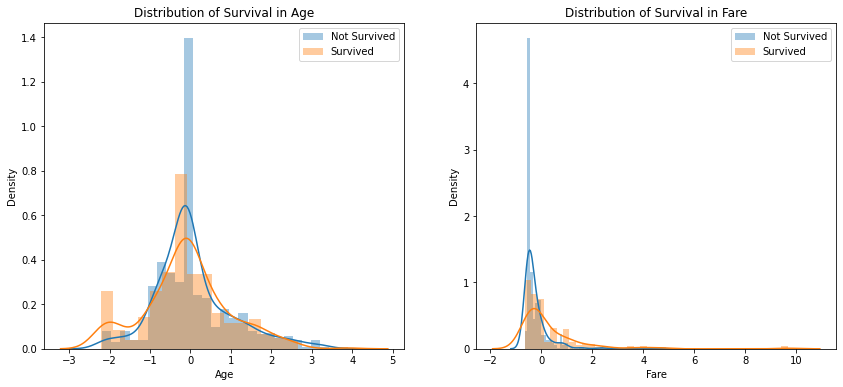

In [146]:
cont_features = ['Age', 'Fare']

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df[df['Survived'] == 0][feature], label='Not Survived', hist=True, ax=ax[i])
    sns.distplot(df[df['Survived'] == 1][feature], label='Survived', hist=True, ax=ax[i])
    
    ax[i].set_xlabel(feature)
    
    ax[i].legend(loc='upper right')
    ax[i].set_title('Distribution of Survival in {}'.format(feature))

plt.show()

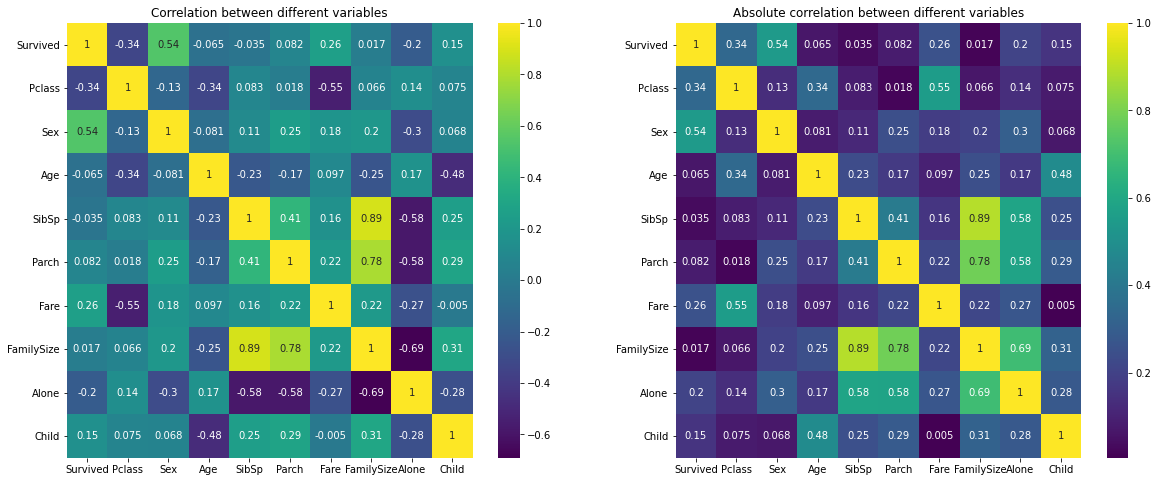

In [147]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].set_title("Correlation between different variables")
ax[1].set_title("Absolute correlation between different variables")
sns.heatmap(df.corr(), annot=True, cmap="viridis", ax=ax[0])
sns.heatmap(abs(df.corr()), annot=True, cmap='viridis', ax=ax[1])
plt.yticks(rotation=0);

## Building a model

Let's use the following features:

- Pclass
- Sex
- Age
- Fare
- Alone

In [148]:
X = df[["Pclass", "Sex", "Age", "Fare", "Alone"]]
X_final = test_df[["Pclass", "Sex", "Age", "Fare", "Alone"]]

y = df["Survived"]

### Random Forest Classifier

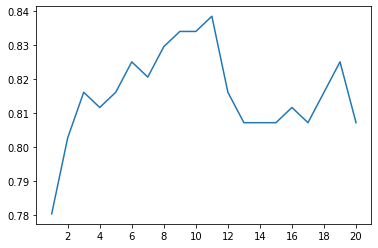

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

acc = []
for k in range(1, 21):
    forest = RandomForestClassifier(max_depth = k).fit(X_train, y_train)
    yhat = forest.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))
    
plt.plot(range(1, 21), acc)
plt.xticks(range(2,21,2));

Best accuracy at a max depth of $k=11$.

### K-Nearest Neighbors

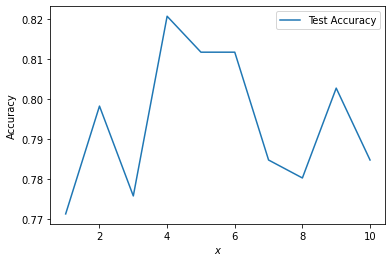

In [150]:
from sklearn.neighbors import KNeighborsClassifier

test_acc = []

for k in range(1, 11):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    test_acc.append(accuracy_score(yhat, y_test))

plt.plot(range(1, 11), test_acc, label='Test Accuracy')
plt.xlabel("$x$")
plt.ylabel("Accuracy")
plt.legend();

Best accuracy at $4$ neighbors.

### Logistic Regression

In [161]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.16, solver='lbfgs', random_state=0).fit(X_train, y_train)
print(accuracy_score(y_test, LR.predict(X_test)))

0.7892376681614349


### Final Model

In [182]:
final_model = RandomForestClassifier(max_depth = 11).fit(X, y)

## Apply the model to the test data

In [183]:
y_final = final_model.predict(X_final)

In [184]:
output = pd.DataFrame({"PassengerId": test_ids, "Survived": y_final})
output.to_csv("titanic_submission_2.csv", index=False)
print("Successful")
print(output)

Successful
     PassengerId  Survived
0            892         1
1            893         0
2            894         0
3            895         1
4            896         0
..           ...       ...
413         1305         1
414         1306         1
415         1307         1
416         1308         1
417         1309         0

[418 rows x 2 columns]


In [180]:
X

,Pclass,Sex,Age,Fare,Alone
0,3,0,-0.565736,-0.502445,0
1,1,1,0.663861,0.786845,0
2,3,1,-0.258337,-0.488854,1
3,1,1,0.433312,0.420730,0
4,3,0,0.433312,-0.486337,1
...,...,...,...,...,...
886,2,0,-0.181487,-0.386671,1
887,1,1,-0.796286,-0.044381,1
888,3,1,-0.104637,-0.176263,0
889,1,0,-0.258337,-0.044381,1


In [181]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64